# Nettoyer un texte : des exercices pour découvrir l’approche

bag-of-words

Lino Galiana  
2024-04-12

Cette page approfondit certains aspects présentés dans la
[partie introductive](../../content/NLP/intro.html). Après avoir travaillé sur le
*Comte de Monte Cristo*, on va continuer notre exploration de la littérature
avec cette fois des auteurs anglophones :

-   Edgar Allan Poe, (EAP) ;
-   HP Lovecraft (HPL) ;
-   Mary Wollstonecraft Shelley (MWS).

Les données sont disponibles sur un CSV mis à disposition sur [`Github`](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/blob/master/data/spooky.csv). L’URL pour les récupérer directement est
<https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv>.

Le but va être dans un premier temps de regarder dans le détail les termes les plus fréquemment utilisés par les auteurs et de les représenter graphiquement. Il s’agit donc d’une approche basée sur l’analyse de fréquences.
On prendra appui sur l’approche *bag of words* présentée dans le chapitre précédent<a name="cite_ref-1"></a>[<sup>\[1\]</sup>](#cite_note-1).
Il n’y aura pas de modélisation particulière, ceci est réservé aux chapitres suivants.

L’approche *bag of words* est déjà, si on la pousse à ses limites, très intéressante. Elle peut notamment
faciliter la mise en cohérence de différents corpus
par la méthode des appariements flous
(cf. [Galiana and Castillo (2022)](https://epic-davinci-acb57b.netlify.app/#1).
Le [chapitre sur ElasticSearch](#elastic) présent dans cette partie du cours présente quelques
éléments de ce travail sur les données de l’`OpenFoodFacts`.

Ce chapitre s’inspire de plusieurs ressources disponibles en ligne:

-   Un [premier *notebook* sur `Kaggle`](https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras)
    et un [deuxième](https://www.kaggle.com/meiyizi/spooky-nlp-and-topic-modelling-tutorial/notebook) ;
-   Un [dépôt `Github`](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg) ;

Les chapitres suivants permettront d’introduire aux enjeux de modélisation
de corpus textuels. Dans un premier temps, le modèle `LDA` permettra d’explorer
le principe des modèles bayésiens à couche cachées pour modéliser les sujets (*topics*)
présents dans un corpus et segmenter ces *topics* selon les mots qui les composent.

Le dernier chapitre de la partie visera à
prédire quel texte correspond à quel auteur à partir d’un modèle `Word2Vec`.
Cela sera un pas supplémentaire dans la formalisation puisqu’il s’agira de
représenter chaque mot d’un texte sous forme d’un vecteur de grande dimension, ce
qui nous permettra de rapprocher les mots entre eux dans un espace complexe.
Cette technique, dite des plongements de mots (*Word Embeddings*),
permet ainsi de transformer une information complexe difficilement quantifiable
comme un mot
en un objet numérique qui peut ainsi être rapproché d’autres par des méthodes
algébriques. Pour découvrir ce concept, ce [post de blog](https://ssphub.netlify.app/post/word-embedding/)
est particulièrement utile. En pratique, la technique des
plongements de mots permet d’obtenir des tableaux comme celui-ci :

<figure id="fig-relevanc-table-embedding">
<img src="https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/word_embedding.png" />
<figcaption>Figure 1: Illustration de l’intérêt des <em>embeddings</em> <span class="citation" data-cites="galianafuzzy">(Galiana and Castillo 2022)</span></figcaption>
</figure>

## Librairies nécessaires

Cette page évoquera les principales librairies pour faire du NLP, notamment :

-   [NLTK](https://www.nltk.org/)
-   [SpaCy](https://spacy.io/)

A celles-ci s’ajoute des librairies de représentations graphiques
synthétiques comme [WordCloud](https://github.com/amueller/word_cloud),
`Gensim` et `Pywaffle`.

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-lightbulb-o"></i> Hint</h3>

Comme dans la [partie précédente](#nlp), il faut télécharger quelques éléments pour que `NTLK` puisse fonctionner correctement. Pour cela, faire :

``` python
import nltk

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("genesis")
nltk.download("wordnet")
nltk.download("omw-1.4")
```

</div>

La liste des modules à importer est assez longue, la voici :

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import base64
import string
import re
import nltk

from collections import Counter
from time import time

# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

#!pip install pywaffle
from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("genesis")
nltk.download("wordnet")
nltk.download("omw-1.4")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yzi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yzi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\yzi\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yzi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\yzi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Données utilisées

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 1 (optionnel): Importer les données spooky</h3>

*Pour ceux qui ont envie de tester leurs connaissances en `Pandas`*

1.  Importer le jeu de données `spooky` à partir de l’URL <https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv> sous le nom `train`. L’encoding est `latin-1`
2.  Mettre des majuscules au nom des colonnes.
3.  Retirer le prefix `id` de la colonne `Id` et appeler la nouvelle colonne `ID`.
4.  Mettre l’ancienne colonne `Id` en index.

</div>

Si vous ne faites pas l’exercice 1, pensez à charger les données en executant la fonction `get_data.py` :

In [45]:
import requests

url = "https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/NLP/get_data.py"
r = requests.get(url, allow_redirects=True)
open("getdata.py", "wb").write(r.content)

import getdata

train = getdata.create_train_dataframes()


Ce code introduit une base nommée `train` dans l’environnement.

Le jeu de données met ainsi en regard un auteur avec une phrase qu’il a écrite :

In [46]:
train.head()


,Text,Author,ID
Id,,,
id26305,"This process, however, afforded me no means of...",EAP,26305
id17569,It never once occurred to me that the fumbling...,HPL,17569
id11008,"In his left hand was a gold snuff box, from wh...",EAP,11008
id27763,How lovely is spring As we looked from Windsor...,MWS,27763
id12958,"Finding nothing else, not even gold, the Super...",HPL,12958


On peut se rendre compte que les extraits des 3 auteurs ne sont
pas forcément équilibrés dans le jeu de données.
Il faudra en tenir compte dans la prédiction.

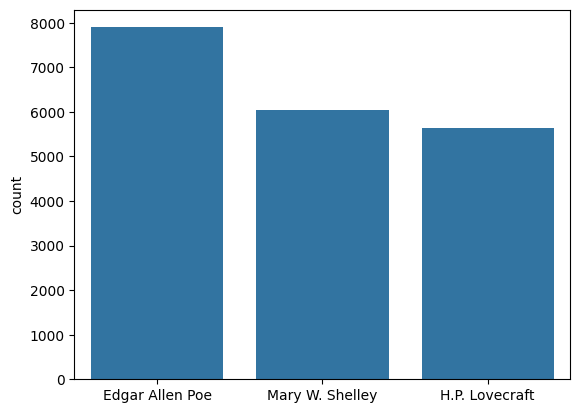

In [47]:
fig = plt.figure()
g = sns.barplot(
    x=["Edgar Allen Poe", "Mary W. Shelley", "H.P. Lovecraft"],
    y=train["Author"].value_counts(),
)


<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

L’approche *bag of words* est présentée de
manière plus extensive dans le [chapitre précédent](#nlp).

L’idée est d’étudier la fréquence des mots d’un document et la
surreprésentation des mots par rapport à un document de
référence (appelé *corpus*).

Cette approche un peu simpliste mais très
efficace : on peut calculer des scores permettant par exemple de faire
de classification automatique de document par thème, de comparer la
similarité de deux documents. Elle est souvent utilisée en première analyse,
et elle reste la référence pour l’analyse de textes mal
structurés (tweets, dialogue tchat, etc.).

Les analyses tf-idf (*term frequency-inverse document frequency*) ou les
constructions d’indices de similarité cosinus reposent sur ce type d’approche.

</div>

### Fréquence d’un mot

Avant de s’adonner à une analyse systématique du champ lexical de chaque
auteur, on va se focaliser dans un premier temps sur un unique mot, le mot *fear*.

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

L’exercice ci-dessous présente une représentation graphique nommée
*waffle chart*. Il s’agit d’une approche préférable aux
camemberts qui sont des graphiques manipulables car l’oeil humain se laisse
facilement berner par cette représentation graphique qui ne respecte pas
les proportions.

</div>

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 2 : Fréquence d'un mot</h3>

1.  Compter le nombre de phrases, pour chaque auteur, où apparaît le mot `fear`.
2.  Utiliser `pywaffle` pour obtenir les graphiques ci-dessous qui résument
    de manière synthétique le nombre d’occurrences du mot *“fear”* par auteur.
3.  Refaire l’analyse avec le mot *“horror”*.

</div>

A l’issue de la question 1, vous devriez obtenir le tableau
de fréquence suivant :

Nombre de phrases contenant le mot 'fear' par auteur: {'MWS': 215, 'HPL': 163, 'EAP': 70}


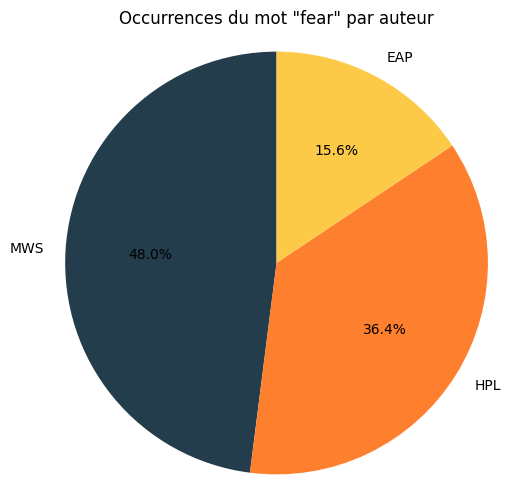

Nombre de phrases contenant le mot 'horror' par auteur: {'HPL': 106, 'EAP': 63, 'MWS': 59}


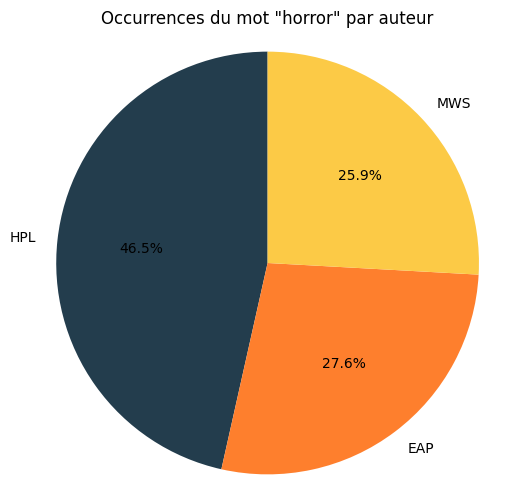

In [48]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Télécharger le script getdata.py depuis GitHub
url = "https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/NLP/get_data.py"
r = requests.get(url, allow_redirects=True)
open("getdata.py", "wb").write(r.content)

# Importer le module getdata
import getdata

# Créer le DataFrame train
train = getdata.create_train_dataframes()

# Fonction pour compter le nombre de phrases contenant un mot donné pour chaque auteur
def count_phrases_with_word(df, word):
    filtered_phrases = df[df['Text'].str.contains(word, case=False)]
    count_by_author = filtered_phrases['Author'].value_counts().to_dict()
    return count_by_author

# Compter le nombre de phrases contenant le mot "fear" pour chaque auteur
fear_count = count_phrases_with_word(train, 'fear')
print("Nombre de phrases contenant le mot 'fear' par auteur:", fear_count)

# Créer un diagramme circulaire pour le mot "fear"
labels = list(fear_count.keys())
sizes = list(fear_count.values())
colors = ['#233D4D', '#FE7F2D', '#FCCA46']

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title('Occurrences du mot "fear" par auteur')
plt.show()

# Compter le nombre de phrases contenant le mot "horror" pour chaque auteur
horror_count = count_phrases_with_word(train, 'horror')
print("Nombre de phrases contenant le mot 'horror' par auteur:", horror_count)

# Créer un diagramme circulaire pour le mot "horror"
labels = list(horror_count.keys())
sizes = list(horror_count.values())
colors = ['#233D4D', '#FE7F2D', '#FCCA46']

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
plt.title('Occurrences du mot "horror" par auteur')
plt.show()


Ceci permet d’obtenir le *waffle chart* suivant :

On remarque ainsi de manière très intuitive
le déséquilibre de notre jeu de données
lorsqu’on se focalise sur le terme *“peur”*
où Mary Shelley représente près de 50%
des observations.

Si on reproduit cette analyse avec le terme *“horror”*, on peut
en conclure que la peur est plus évoquée par Mary Shelley
(sentiment assez naturel face à la créature du docteur Frankenstein) alors
que Lovecraft n’a pas volé sa réputation d’écrivain de l’horreur !

### Premier *wordcloud*

Pour aller plus loin dans l’analyse du champ lexical de chaque auteur,
on peut représenter un `wordcloud` qui permet d’afficher chaque mot avec une
taille proportionnelle au nombre d’occurrence de celui-ci.

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 3 : Wordcloud</h3>

1.  En utilisant la fonction `wordCloud`, faire trois nuages de mot pour représenter les mots les plus utilisés par chaque auteur.
2.  Calculer les 25 mots plus communs pour chaque auteur et représenter les trois histogrammes des décomptes.

</div>

Le *wordcloud* pour nos différents auteurs est le suivant :

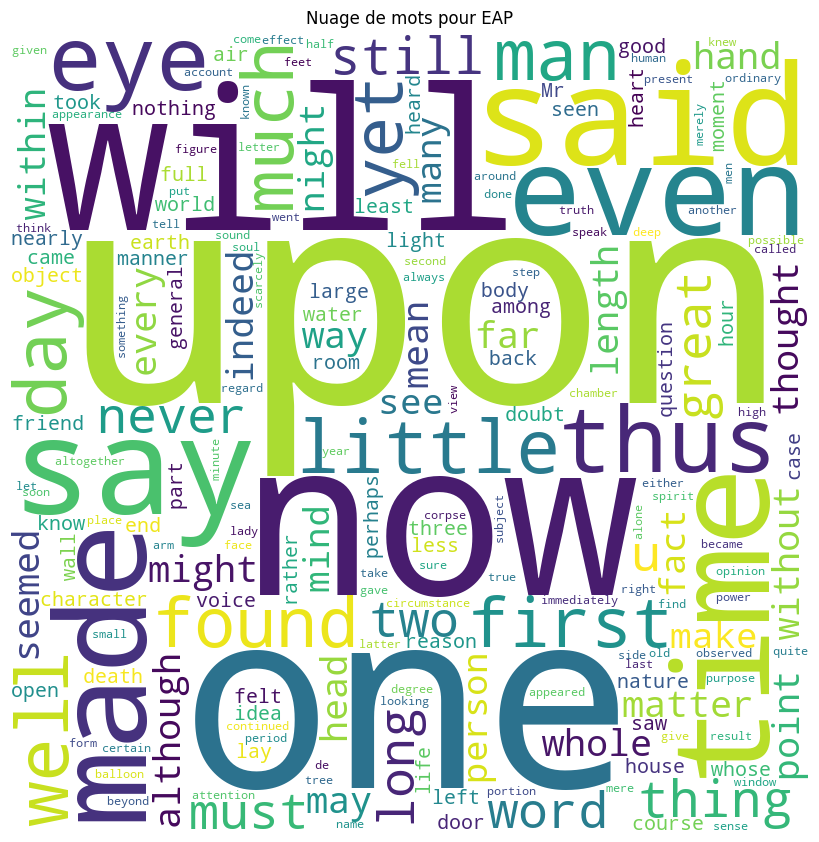

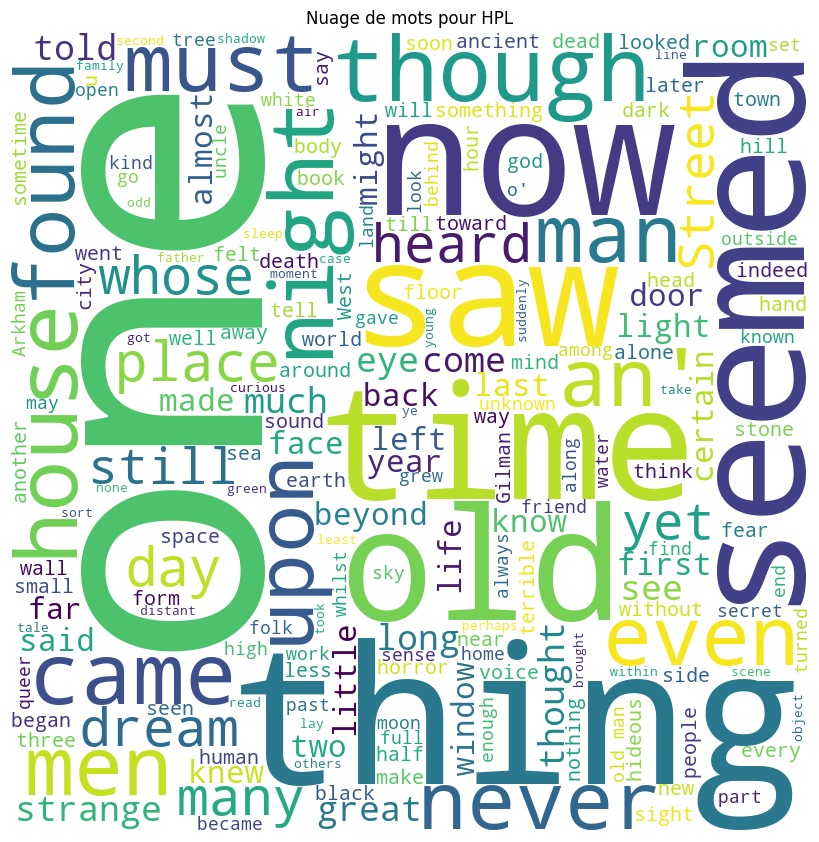

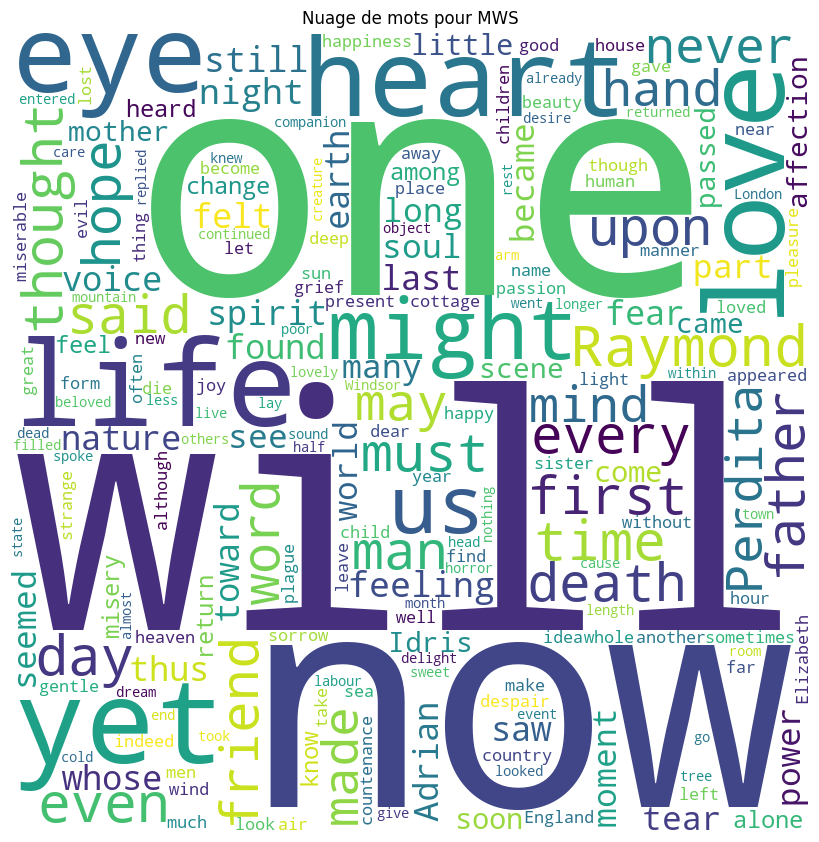

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Création d'un nuage de mots pour un auteur donné
def create_wordcloud(text, title):
    wordcloud = WordCloud(width = 800, height = 800, 
                          background_color ='white', 
                          min_font_size = 10).generate(text)

    # Affichage du nuage de mots généré
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title)
    plt.show()

# Combinez les textes de chaque auteur dans une seule chaîne
authors = train['Author'].unique()
author_texts = {author: ' '.join(train[train['Author'] == author]['Text']) for author in authors}

# Créez et affichez un nuage de mots pour chaque auteur
for author, text in author_texts.items():
    create_wordcloud(text, f"Nuage de mots pour {author}")


Enfin, si on fait un histogramme des fréquences,
cela donnera :

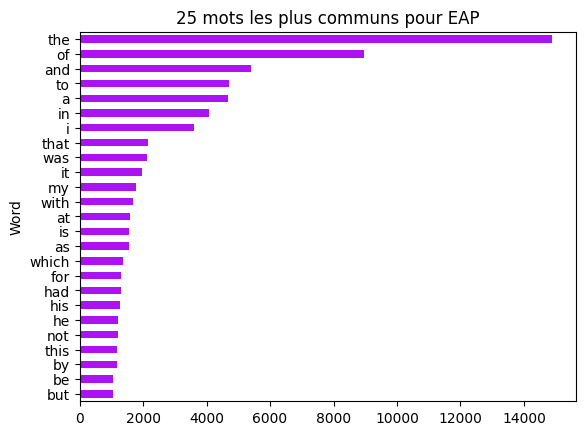

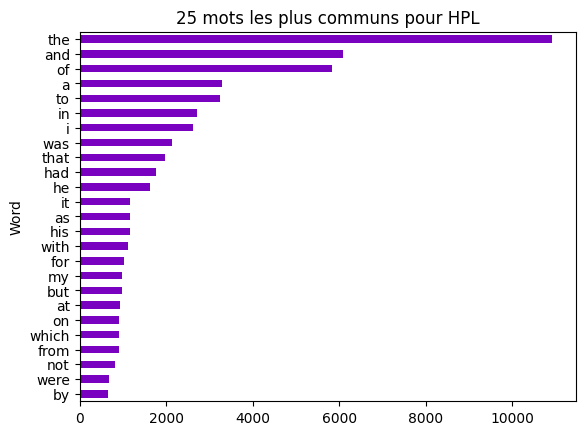

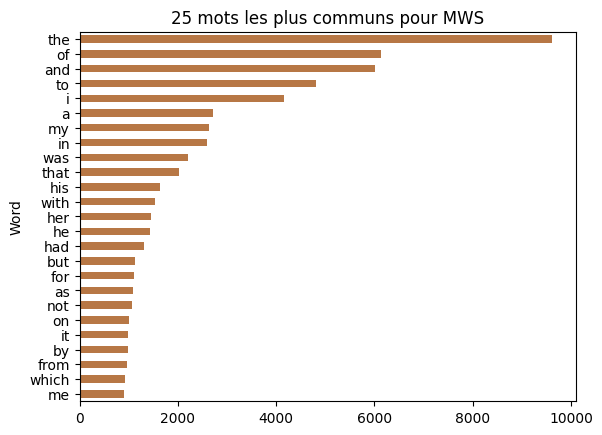

In [50]:
from collections import Counter
import pandas as pd
import numpy as np

# Fonction pour calculer les 25 mots les plus fréquents pour un auteur donné
def common_words_histogram(text, author):
    # Créez un compteur de tous les mots (en minuscules) et identifiez les 25 mots les plus courants
    words = text.lower().split()
    most_common = Counter(words).most_common(25)
    
    # Création d'un DataFrame à partir des mots les plus communs
    df = pd.DataFrame(most_common, columns=['Word', 'Count'])
    
    # Création d'un histogramme
    df.sort_values(by='Count', ascending=True).plot.barh(x='Word', y='Count',
                                                          legend=False, color=np.random.rand(3,),
                                                          title=f'25 mots les plus communs pour {author}')
    plt.show()

# Affichez les histogrammes pour chaque auteur
for author, text in author_texts.items():
    common_words_histogram(text, author)


On voit ici que ce sont des mots communs, comme *“the”*, *“of”*, etc. sont très
présents. Mais ils sont peu porteurs d’information, on peut donc les éliminer
avant de faire une analyse syntaxique poussée.
Ceci est une démonstration par l’exemple qu’il vaut mieux nettoyer le texte avant de
l’analyser (sauf si on est intéressé
par la loi de Zipf, cf. exercice suivant).

A noter que l’histogramme produit
par le biais de `Matplotlib` ou `Seaborn` est
peu lisible. Il vaut mieux privilégier `Plotly`
pour faire celui-ci afin d’avoir les mots qui s’affichent en
passant sa souris sur chaque barre.

### Aparté : la loi de Zipf

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> La loi de Zipf</h3>

Dans son sens strict, la loi de Zipf prévoit que
dans un texte donné, la fréquence d’occurrence $f(n_i)$ d’un mot est
liée à son rang $n_i$ dans l’ordre des fréquences par une loi de la forme
$f(n_i) = c/n_i$ où $c$ est une constante. Zipf, dans les années 1930, se basait sur l’oeuvre
de Joyce, *Ulysse* pour cette affirmation.

Plus généralement, on peut dériver la loi de Zipf d’une distribution exponentielle des fréquences : $f(n_i) = cn_{i}^{-k}$. Cela permet d’utiliser la famille des modèles linéaires généralisés, notamment les régressions poissonniennes, pour mesurer les paramètres de la loi. Les modèles linéaire traditionnels en `log` souffrent en effet, dans ce contexte, de biais (la loi de Zipf est un cas particulier d’un modèle gravitaire, où appliquer des OLS est une mauvaise idée, cf. [Galiana et al. (2020)](https://linogaliana.netlify.app/publication/2020-segregation/) pour les limites).

</div>

Un modèle exponentiel peut se représenter par un modèle de Poisson ou, si
les données sont très dispersées, par un modèle binomial négatif. Pour
plus d’informations, consulter l’annexe de Galiana et al. (2020).
La technique économétrique associée pour l’estimation est
les modèles linéaires généralisés (GLM) qu’on peut
utiliser en `Python` via le
package \`statsmodels\``{=html} <a name="cite_note-3"></a>3. [^](#cite_ref-3)`

La littérature sur les modèles gravitaires, présentée dans Galiana et al. (2020),
donne quelques arguments pour privilégier les modèles GLM à des modèles log-linéaires
estimés par moindres carrés ordinaires.

$$
\mathbb{E}\bigg( f(n_i)|n_i \bigg) = \exp(\beta_0 + \beta_1 \log(n_i))
$$

Prenons les résultats de l’exercice précédent et enrichissons les du rang et de la fréquence d’occurrence d’un mot :

In [51]:
count_words = pd.DataFrame(
    {
        "counter": train.groupby("Author")
        .apply(lambda s: " ".join(s["Text"]).split())
        .apply(lambda s: Counter(s))
        .apply(lambda s: s.most_common())
        .explode()
    }
)
count_words[["word", "count"]] = pd.DataFrame(
    count_words["counter"].tolist(), index=count_words.index
)
count_words = count_words.reset_index()

count_words = count_words.assign(
    tot_mots_auteur=lambda x: (x.groupby("Author")["count"].transform("sum")),
    freq=lambda x: x["count"] / x["tot_mots_auteur"],
    rank=lambda x: x.groupby("Author")["count"].transform("rank", ascending=False),
)


C:\Users\yzi\AppData\Local\Temp\ipykernel_12068\4090456936.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Commençons par représenter la relation entre la fréquence et le rang:

In [52]:
from plotnine import *

g = (
    ggplot(count_words)
    + geom_point(aes(y="freq", x="rank", color="Author"), alpha=0.4)
    + scale_x_log10()
    + scale_y_log10()
    + theme_minimal()
)


Nous avons bien, graphiquement, une relation log-linéaire entre les deux :

Avec `statsmodels`, vérifions plus formellement cette relation:

In [53]:
import statsmodels.api as sm

exog = sm.add_constant(np.log(count_words["rank"].astype(float)))

model = sm.GLM(
    count_words["freq"].astype(float), exog, family=sm.families.Poisson()
).fit()

# Afficher les résultats du modèle
print(model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   freq   No. Observations:                69301
Model:                            GLM   Df Residuals:                    69299
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.011
Date:                Tue, 16 Apr 2024   Deviance:                     0.065676
Time:                        13:48:39   Pearson chi2:                   0.0656
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0002431
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4388      1.089     -2.239      0.0

Le coefficient de la régression est presque 1 ce qui suggère bien une relation
quasiment log-linéaire entre le rang et la fréquence d’occurrence d’un mot.
Dit autrement, le mot le plus utilisé l’est deux fois plus que le deuxième mot le plus fréquent qui l’est trois plus que le troisième, etc.

## Nettoyage d’un texte

Les premières étapes dans le nettoyage d’un texte, qu’on a
développé au cours du [chapitre précédent](../../content/NLP/01_intro.html), sont :

-   suppression de la ponctuation ;
-   suppression des *stopwords*.

Cela passe par la tokenisation d’un texte, c’est-à-dire la décomposition
de celui-ci en unités lexicales (les *tokens*).
Ces unités lexicales peuvent être de différentes natures,
selon l’analyse que l’on désire mener.
Ici, on va définir les tokens comme étant les mots utilisés.

Plutôt que de faire soi-même ce travail de nettoyage,
avec des fonctions mal optimisées,
on peut utiliser la librairie `nltk` comme détaillé [précédemment](../../content/NLP/01_intro.html).

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 4 : Nettoyage du texte</h3>

Repartir de `train`, notre jeu de données d’entraînement.

1.  Tokeniser chaque phrase avec `nltk`.
2.  Retirer les stopwords avec `nltk`.

</div>

Pour rappel, au début de l’exercice, `train` présente l’aspect suivant :

In [54]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Récupérer la liste des stopwords en anglais
stop_words = set(stopwords.words('english'))

# Fonction pour nettoyer le texte
def clean_text(text):
    # Tokenisation : division du texte en mots (tokens)
    tokens = word_tokenize(text)
    # Suppression des stopwords
    tokens = [word for word in tokens if not word.lower() in stop_words]
    return tokens

# Appliquer la fonction de nettoyage à chaque phrase du DataFrame
train['Cleaned_Text'] = train['Text'].apply(clean_text)

# Vérifiez les résultats
print(train[['Text', 'Cleaned_Text']].head())


                                                      Text  \
Id                                                           
id26305  This process, however, afforded me no means of...   
id17569  It never once occurred to me that the fumbling...   
id11008  In his left hand was a gold snuff box, from wh...   
id27763  How lovely is spring As we looked from Windsor...   
id12958  Finding nothing else, not even gold, the Super...   

                                              Cleaned_Text  
Id                                                          
id26305  [process, ,, however, ,, afforded, means, asce...  
id17569  [never, occurred, fumbling, might, mere, mista...  
id11008  [left, hand, gold, snuff, box, ,, ,, capered, ...  
id27763  [lovely, spring, looked, Windsor, Terrace, six...  
id12958  [Finding, nothing, else, ,, even, gold, ,, Sup...  


Après tokenisation, il devrait avoir cet aspect :

Après le retrait des stopwords, cela donnera :

<div class="alert alert-warning" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #ffc10780;">
<h3 class="alert-heading"><i class="fa fa-lightbulb-o"></i> Hint</h3>

La méthode `apply` est très pratique ici car nous avons une phrase par ligne. Plutôt que de faire un `DataFrame` par auteur, ce qui n’est pas une approche très flexible, on peut directement appliquer la tokenisation
sur notre `DataFrame` grâce à `apply`, sans le diviser.

</div>

Ce petit nettoyage permet d’arriver à un texte plus intéressant en termes d’analyse lexicale. Par exemple, si on reproduit l’analyse précédente… :

In [55]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Définis les stopwords en français, car ton profil indique que tu es en France
# Si tes données sont en anglais, remplace 'french' par 'english'
stop_words = set(stopwords.words('english'))

# Fonction pour tokeniser et retirer les stop words
def tokenize_and_remove_stopwords(text):
    # Tokenise le texte
    tokens = word_tokenize(text, language='english')  # Spécifie la langue si nécessaire
    # Retire les stop words et les tokens qui ne sont pas alphabétiques
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Applique cette fonction à chaque ligne de la colonne 'Text' dans le DataFrame
train['Tokens'] = train['Text'].apply(tokenize_and_remove_stopwords)

# Affiche les premiers résultats pour vérifier
print(train[['Text', 'Tokens']].head())


                                                      Text  \
Id                                                           
id26305  This process, however, afforded me no means of...   
id17569  It never once occurred to me that the fumbling...   
id11008  In his left hand was a gold snuff box, from wh...   
id27763  How lovely is spring As we looked from Windsor...   
id12958  Finding nothing else, not even gold, the Super...   

                                                    Tokens  
Id                                                          
id26305  [This, process, however, afforded, means, asce...  
id17569  [It, never, occurred, fumbling, might, mere, m...  
id11008  [In, left, hand, gold, snuff, box, capered, hi...  
id27763  [How, lovely, spring, As, looked, Windsor, Ter...  
id12958  [Finding, nothing, else, even, gold, Superinte...  


Pour aller plus loin dans l’harmonisation d’un texte, il est possible de
mettre en place les classes d’équivalence développées dans la
[partie précédente](../../content/NLP/01_intro.html) afin de remplacer différentes variations d’un même
mot par une forme canonique :

-   la **racinisation** (*stemming*) assez fruste mais rapide, notamment
    en présence de fautes d’orthographe. Dans ce cas, *chevaux* peut devenir *chev*
    mais être ainsi confondu avec *chevet* ou *cheveux*.
    Cette méthode est généralement plus simple à mettre en oeuvre, quoique
    plus fruste.

-   la **lemmatisation** qui requiert la connaissance des statuts
    grammaticaux (exemple : *chevaux* devient *cheval*).
    Elle est mise en oeuvre, comme toujours avec `nltk`, à travers un
    modèle. En l’occurrence, un `WordNetLemmatizer` (WordNet est une base
    lexicographique ouverte). Par exemple, les mots *“women”*, *“daughters”*
    et *“leaves”* seront ainsi lemmatisés de la manière suivante :

In [56]:
from nltk.stem import WordNetLemmatizer

lemm = WordNetLemmatizer()

for word in ["women", "daughters", "leaves"]:
    print(f"The lemmatized form of {word} is: {lemm.lemmatize(word)}")


The lemmatized form of women is: woman
The lemmatized form of daughters is: daughter
The lemmatized form of leaves is: leaf


<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

Pour disposer du corpus nécessaire à la lemmatisation, il faut, la première fois,
télécharger celui-ci grâce aux commandes suivantes :

``` python
import nltk

nltk.download("wordnet")
nltk.download("omw-1.4")
```

</div>

On va se restreindre au corpus d’Edgar Allan Poe et repartir de la base de données
brute :

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 5 : Lemmatisation avec nltk</h3>

Utiliser un `WordNetLemmatizer` et observer le résultat.

Optionnel : Effectuer la même tâche avec `spaCy`

</div>

Le `WordNetLemmatizer` donnera le résultat suivant :

In [57]:
from nltk.stem import WordNetLemmatizer

# Initialiser le lemmatiseur
lemmatizer = WordNetLemmatizer()

# Fonction pour lemmatiser les tokens
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Appliquer la fonction de lemmatisation à chaque ligne de la colonne 'Tokens'
train['Lemmatized'] = train['Tokens'].apply(lemmatize_tokens)

# Afficher les résultats pour vérifier
print(train[['Text', 'Tokens', 'Lemmatized']].head())


                                                      Text  \
Id                                                           
id26305  This process, however, afforded me no means of...   
id17569  It never once occurred to me that the fumbling...   
id11008  In his left hand was a gold snuff box, from wh...   
id27763  How lovely is spring As we looked from Windsor...   
id12958  Finding nothing else, not even gold, the Super...   

                                                    Tokens  \
Id                                                           
id26305  [This, process, however, afforded, means, asce...   
id17569  [It, never, occurred, fumbling, might, mere, m...   
id11008  [In, left, hand, gold, snuff, box, capered, hi...   
id27763  [How, lovely, spring, As, looked, Windsor, Ter...   
id12958  [Finding, nothing, else, even, gold, Superinte...   

                                                Lemmatized  
Id                                                          
id26305 

## TF-IDF: calcul de fréquence

Le calcul [tf-idf](https://fr.wikipedia.org/wiki/TF-IDF) (term *frequency–inverse document frequency*)
permet de calculer un score de proximité entre un terme de recherche et un
document (c’est ce que font les moteurs de recherche).

-   La partie `tf` calcule une fonction croissante de la fréquence du terme de recherche dans le document à l’étude ;
-   La partie `idf` calcule une fonction inversement proportionnelle à la fréquence du terme dans l’ensemble des documents (ou corpus).

Le score total, obtenu en multipliant les deux composantes,
permet ainsi de donner un score d’autant plus élevé que le terme est surréprésenté dans un document
(par rapport à l’ensemble des documents).
Il existe plusieurs fonctions, qui pénalisent plus ou moins les documents longs,
ou qui sont plus ou moins *smooth*.

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 6 : TF-IDF: calcul de fréquence</h3>

1.  Utiliser le vectoriseur TF-IdF de `scikit-learn` pour transformer notre corpus en une matrice `document x terms`. Au passage, utiliser l’option `stop_words` pour ne pas provoquer une inflation de la taille de la matrice. Nommer le modèle `tfidf` et le jeu entraîné `tfs`.
2.  Après avoir construit la matrice de documents x terms avec le code suivant, rechercher les lignes où les termes ayant la structure `abandon` sont non-nuls.
3.  Trouver les 50 extraits où le score TF-IDF est le plus élevé et l’auteur associé. Vous devriez obtenir le classement suivant :

</div>

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialiser le vectoriseur TF-IDF avec suppression des stop words anglais
# Tu peux changer 'english' en 'french' si ton corpus est en français
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Entraîner le modèle TF-IDF et transformer le corpus
tfs = tfidf_vectorizer.fit_transform(train['Text'])

# Le modèle tfidf est simplement tfidf_vectorizer qui a déjà été entraîné
tfidf = tfidf_vectorizer


Les lignes où les termes de abandon sont non nuls
sont les suivantes :

In [59]:
# Trouver l'index du terme "abandon" (ou "abandon*" pour les variantes) dans le vocabulaire
# La méthode get_feature_names_out() te donne tous les termes du vocabulaire
term = 'abandon'
term_index = tfidf_vectorizer.vocabulary_.get(term)

# Trouver les documents où le terme est présent
if term_index:  # Assurez-vous que le terme existe dans le vocabulaire
    # Extraire la colonne correspondant au terme dans la matrice TF-IDF
    term_column = tfs[:, term_index]

    # Trouver les documents où le score TF-IDF pour ce terme est non-nul
    non_zero_rows = term_column.nonzero()[0]

    # Afficher les informations demandées
    for doc_index in non_zero_rows:
        print(f"Document {doc_index}, Score TF-IDF: {term_column[doc_index, 0]}, Auteur: {train.iloc[doc_index]['Author']}")


Document 215, Score TF-IDF: 0.24909048837051445, Auteur: HPL
Document 839, Score TF-IDF: 0.312171762236029, Auteur: HPL
Document 5694, Score TF-IDF: 0.3289409009901127, Auteur: HPL
Document 9013, Score TF-IDF: 0.3625896915213885, Auteur: EAP
Document 9560, Score TF-IDF: 0.39757329915195083, Auteur: EAP
Document 12189, Score TF-IDF: 0.38857069778719827, Auteur: MWS
Document 13666, Score TF-IDF: 0.24672171132436735, Auteur: EAP
Document 16516, Score TF-IDF: 0.410290931705748, Auteur: EAP
Document 18019, Score TF-IDF: 0.335673154060485, Auteur: EAP
Document 18126, Score TF-IDF: 0.3607369996454269, Auteur: EAP
Document 18251, Score TF-IDF: 0.4013724467155116, Auteur: EAP


In [60]:
import numpy as np

# Assurez-vous que le terme existe dans le vocabulaire
if term_index:
    # Créer un tableau de tous les scores TF-IDF pour ce terme
    term_scores = tfs[:, term_index].toarray().flatten()

    # Trouver les indices des 50 plus grands scores
    top_50_indices = np.argsort(term_scores)[-50:]

    # Afficher les extraits correspondants et les auteurs
    for doc_index in top_50_indices:
        print(f"Extrait: {train.iloc[doc_index]['Text'][:100]}... (continues), Score TF-IDF: {term_scores[doc_index]}, Auteur: {train.iloc[doc_index]['Author']}")


Extrait: What do you intend to do?" "To go instantly to Geneva: come with me, Henry, to order the horses."... (continues), Score TF-IDF: 0.0, Auteur: MWS
Extrait: In none is there any effort at plausibility in the details of the voyage itself.... (continues), Score TF-IDF: 0.0, Auteur: EAP
Extrait: Upon detaching the slab, a cavity appeared, containing a leaden box filled with various coins, a lon... (continues), Score TF-IDF: 0.0, Auteur: EAP
Extrait: I was admitted within that sacred boundary which divides the intellectual and moral nature of man fr... (continues), Score TF-IDF: 0.0, Auteur: MWS
Extrait: Dombrowski, frantic at the failure of his constant rat poisoning efforts, cast aside all thought of ... (continues), Score TF-IDF: 0.0, Auteur: HPL
Extrait: The air had begun to be exceedingly unwholesome; but to this detail he paid no attention as he toile... (continues), Score TF-IDF: 0.0, Auteur: HPL
Extrait: He had often talked about her in my presence, however, and in his usual 

Les 10 scores les plus élevés sont les suivants :

In [61]:
import numpy as np

# On suppose que 'tfs' est déjà la matrice TF-IDF et 'tfidf_vectorizer' est le modèle TF-IDF
# Assurez-vous que le terme existe dans le vocabulaire
term = 'abandon'
term_index = tfidf_vectorizer.vocabulary_.get(term)

if term_index is not None:
    # Créer un tableau de tous les scores TF-IDF pour ce terme
    term_scores = tfs[:, term_index].toarray().flatten()

    # Trouver les indices des 10 plus grands scores
    top_10_indices = np.argsort(term_scores)[-10:]

    # Récupérer les 10 scores les plus élevés et les auteurs associés
    top_10_scores = term_scores[top_10_indices]
    top_10_authors = train.iloc[top_10_indices]['Author']

    # Afficher les résultats
    for score, author, doc_index in zip(top_10_scores, top_10_authors, top_10_indices):
        excerpt = train.iloc[doc_index]['Text']
        print(f"Score TF-IDF: {score}, Auteur: {author}, Extrait: {excerpt[:100]}... (continues)")
else:
    print(f"Le terme '{term}' n'est pas trouvé dans le corpus.")


Score TF-IDF: 0.24909048837051445, Auteur: HPL, Extrait: All in all, he became a disconcerting and even gruesome companion; yet in my gratitude for his heali... (continues)
Score TF-IDF: 0.312171762236029, Auteur: HPL, Extrait: I had already decided not to abandon the quest for the lurking fear, for in my rash ignorance it see... (continues)
Score TF-IDF: 0.3289409009901127, Auteur: HPL, Extrait: At one time he threatened to abandon the expedition if I remained insistent; a threat which proved e... (continues)
Score TF-IDF: 0.335673154060485, Auteur: EAP, Extrait: to be enamored of the Night for her own sake; and into this bizarrerie, as into all his others, I qu... (continues)
Score TF-IDF: 0.3607369996454269, Auteur: EAP, Extrait: In a word, why did he abandon four thousand francs in gold to encumber himself with a bundle of line... (continues)
Score TF-IDF: 0.3625896915213885, Auteur: EAP, Extrait: He stretched forth to me his hand, and unfortunately in so doing was forced to abando

On remarque que les scores les plus élevés sont soient des extraits courts où le mot apparait une seule fois, soit des extraits plus longs où le mot fear apparaît plusieurs fois.

<div class="alert alert-info" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #007bff80;">
<h3 class="alert-heading"><i class="fa fa-comment"></i> Note</h3>

La matrice `document x terms` est un exemple typique de matrice *sparse* puisque, dans des corpus volumineux, une grande diversité de vocabulaire peut être trouvée.

</div>

## Approche contextuelle : les *n-grams*

Jusqu’à présent, dans l’approche *bag of words*, l’ordre des mots n’avait pas d’importance.
On considère qu’un texte est une collection de
mots tirés indépendamment, de manière plus ou moins fréquente en fonction de leur probabilité
d’occurrence. Cependant, tirer un mot particulier n’affecte pas les chances de tirer certains mots
ensuite, de manière conditionnelle.

Une manière d’introduire des liens entre les séries de *tokens* sont les *n-grams*.
On s’intéresse non seulement aux mots et à leur fréquence, mais aussi aux mots qui suivent. Cette approche est essentielle pour désambiguiser les homonymes. Le calcul de *n-grams* [1] constitue la méthode la plus simple pour tenir compte du contexte.

Pour être en mesure de mener cette analyse, il est nécessaire de télécharger un corpus supplémentaire :

[1] On parle de *bigrams* pour les co-occurences de mots deux-à-deux, *trigrams* pour les co-occurences trois-à-trois, etc.

In [62]:
import nltk

nltk.download("genesis")
nltk.corpus.genesis.words("english-web.txt")


[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\yzi\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!


['In', 'the', 'beginning', 'God', 'created', 'the', ...]

`NLTK` offre des methodes pour tenir compte du contexte. Pour ce faire, nous calculons les n-grams, c’est-à-dire l’ensemble des co-occurrences successives de mots n-à-n. En général, on se contente de bi-grams, au mieux de tri-grams:

-   les modèles de classification, analyse du sentiment, comparaison de documents, etc. qui comparent des n-grams avec n trop grands sont rapidement confrontés au problème de données sparse, cela réduit la capacité prédictive des modèles ;
-   les performances décroissent très rapidement en fonction de n, et les coûts de stockage des données augmentent rapidement (environ n fois plus élevé que la base de données initiale).

On va, rapidement, regarder dans quel contexte apparaît le mot `fear` dans
l’oeuvre d’Edgar Allan Poe (EAP). Pour cela, on transforme d’abord
le corpus EAP en tokens `NLTK` :

In [63]:
eap_clean = train[train["Author"] == "EAP"]
eap_clean = " ".join(eap_clean["Text"])
tokens = eap_clean.split()
print(tokens[:10])
text = nltk.Text(tokens)
print(text)


['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the']
<Text: This process, however, afforded me no means of...>


Vous aurez besoin des fonctions `BigramCollocationFinder.from_words` et `BigramAssocMeasures.likelihood_ratio` :

<div class="alert alert-success" role="alert" style="color: rgba(0,0,0,.8); background-color: white; margin-top: 1em; margin-bottom: 1em; margin:1.5625emauto; padding:0 .6rem .8rem!important;overflow:hidden; page-break-inside:avoid; border-radius:.25rem; box-shadow:0 .2rem .5rem rgba(0,0,0,.05),0 0 .05rem rgba(0,0,0,.1); transition:color .25s,background-color .25s,border-color .25s ; border-right: 1px solid #dee2e6 ; border-top: 1px solid #dee2e6 ; border-bottom: 1px solid #dee2e6 ; border-left:.2rem solid #3fb618;">
<h3 class="alert-heading"><i class="fa fa-pencil"></i> Exercice 7  : n-grams et contexte du mot fear</h3>

1.  Utiliser la méthode `concordance` pour afficher le contexte dans lequel apparaît le terme `fear`.
2.  Sélectionner et afficher les meilleures collocations, par exemple selon le critère du ratio de vraisemblance.

Lorsque deux mots sont fortement associés, cela est parfois dû au fait qu’ils apparaissent rarement. Il est donc parfois nécessaire d’appliquer des filtres, par exemple ignorer les bigrammes qui apparaissent moins de 5 fois dans le corpus.

1.  Refaire la question précédente en utilisant toujours un modèle `BigramCollocationFinder` suivi de la méthode `apply_freq_filter` pour ne conserver que les bigrammes présents au moins 5 fois. Puis, au lieu d’utiliser la méthode de maximum de vraisemblance, testez la méthode `nltk.collocations.BigramAssocMeasures().jaccard`.

2.  Ne s’intéresser qu’aux *collocations* qui concernent le mot *fear*

</div>

Avec la méthode `concordance` (question 1),
la liste devrait ressembler à celle-ci :

In [64]:
from nltk.text import Text

# Convertir toute la colonne 'Text' de ton DataFrame en une seule chaîne de texte
# et créer un objet NLTK Text pour faciliter l'analyse du contexte
words = word_tokenize(" ".join(train['Text'].tolist()))
text_nltk = Text(words)

# Afficher le contexte d'apparition de "fear"
text_nltk.concordance("fear")


Displaying 25 of 241 matches:
chicken certainly not . '' Perpetual fear had jaundiced his complexion , and s
ent now , as though holding a secret fear . They still appeared in public toge
en they were together , unchecked by fear , she opened her heart to the fulles
hen , as I remained , paralysed with fear , he found his voice and in his dyin
d they are sufficient to conquer all fear of danger or death and to induce me 
r a moment I was almost paralized by fear ; but my energy returned and I deman
own horror I sought , there was more fear in the thought of telling anybody . 
 light heart , for what had I now to fear ? I reason a priori , and a diddle w
with evident effort . A paralysis of fear stifled all attempts to cry out . I 
d quick unequal spoken apparently in fear as well as in anger . What he said w
ed resolved to give all scruple , or fear , to the wind . It was he who had gi
ething lacked it no longer , yet did fear and hatred and ignorance still brood
to abandon the quest f

Même si on peut facilement voir le mot avant et après, cette liste est assez difficile à interpréter car elle recoupe beaucoup d’informations.

La `collocation` consiste à trouver les bi-grammes qui
apparaissent le plus fréquemment ensemble. Parmi toutes les paires de deux mots observées,
il s’agit de sélectionner, à partir d’un modèle statistique, les “meilleures”.
On obtient donc avec cette méthode (question 2):

In [68]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Préparation du texte
text = " ".join(train['Text'].tolist())
tokens = word_tokenize(text)
tokens = [token.lower() for token in tokens if token.isalpha() and token not in stopwords.words('english')]

# Créer un BigramCollocationFinder pour le texte entier
finder = BigramCollocationFinder.from_words(tokens, window_size=2)

# Filtrer pour ne conserver que les bigrammes contenant 'fear'
fear_filter = lambda *w: 'fear' not in w
finder.apply_ngram_filter(fear_filter)

# Appliquer un filtre de fréquence
finder.apply_freq_filter(3)

# Utiliser différentes mesures pour identifier les meilleures collocations
bigram_measures = BigramAssocMeasures()
scored = finder.score_ngrams(bigram_measures.likelihood_ratio)

# Afficher les 10 meilleures collocations avec 'fear'
top_collocations = scored[:10]
for collocation, score in top_collocations:
    print(collocation, score)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yzi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yzi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


('lurking', 'fear') 102.40701947910536
('i', 'fear') 50.24073743012593
('fear', 'lest') 32.99715220299346
('hope', 'fear') 11.699910684903031
('fear', 'i') 9.7137945520283
('fear', 'nothing') 9.296423962875986
('fear', 'death') 7.795756103701675
('fear', 'in') 5.4931406628419985
('fear', 'even') 4.859787748363014
('yet', 'fear') 4.75792824040437


Si on modélise les meilleures collocations:

Cette liste a un peu plus de sens,
on a des noms de personnages, de lieux mais aussi des termes fréquemment employés ensemble
(*Chess Player* par exemple).

En ce qui concerne les *collocations* du mot fear :

Si on mène la même analyse pour le terme *love*, on remarque que de manière logique, on retrouve bien des sujets généralement accolés au verbe :

In [69]:
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Préparation du texte
text = " ".join(train['Text'].tolist())
tokens = word_tokenize(text)
tokens = [token.lower() for token in tokens if token.isalpha() and token not in stopwords.words('english')]

# Créer un BigramCollocationFinder pour le texte entier
finder = BigramCollocationFinder.from_words(tokens, window_size=2)

# Filtrer pour ne conserver que les bigrammes contenant 'fear'
love_filter = lambda *w: 'love' not in w
finder.apply_ngram_filter(love_filter)

# Appliquer un filtre de fréquence
finder.apply_freq_filter(3)

# Utiliser différentes mesures pour identifier les meilleures collocations
bigram_measures = BigramAssocMeasures()
scored = finder.score_ngrams(bigram_measures.likelihood_ratio)

# Afficher les 10 meilleures collocations avec 'fear'
top_collocations = scored[:10]
for collocation, score in top_collocations:
    print(collocation, score)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yzi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yzi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


('brotherly', 'love') 35.962077874516936
('sincerely', 'love') 26.983505596352906
('love', 'child') 25.75525641027329
('mutual', 'love') 25.47452276307317
('love', 'sympathy') 23.92248850862036
('love', 'hope') 21.398490739700176
('spirit', 'love') 21.05764265539305
('passionate', 'love') 20.81209718276763
('feeling', 'love') 19.488337662470734
('love', 'honour') 19.23456136947204


## Références

Galiana, Lino, and Milena Suarez Castillo. 2022. “Fuzzy Matching on Big-Data an Illustration with Scanner Data and Crowd-Sourced Nutritional Data.”

Galiana, Lino, François Sémécurbe, Benjamin Sakarovitch, and Zbigniew Smoreda. 2020. “Residential Segregation, Daytime Segregation and Spatial Frictions: An Analysis from Mobile Phone Data.”